# 7. Ordinary differential equations II


## 7.1 Recap

Numerical libraries have plenty of methods for solving initial value problems, which they usually ask for in the standard form

\begin{align}
\mathbf{u}'(t) &= f(\mathbf{u}(t)), \quad t \in [a, b], \\
\mathbf{u}(a) &= \mathbf{u}_0,
\end{align}

i.e. as a system of first-order ODEs. They will **require** as inputs
* the right-hand-side $f(t, u)$,
* the solution interval $[a, b]$,
* and the initial state $u_0$.
Optionally, you can usually set
* the relative and absolute tolerances of the method,
* the order of the method (this determines the order of accuracy),
* whether to interpolate the solution onto a dense grid (dense output),
* and sometimes some special stopping conditions.

IVP solution methods are generally "marching" or "time-stepping" methods with 3 components,
* A method to approximate / forecast the unknown $u$ with,
* A method to estimate the error of this approximation,
* And a method that uses this error estimate to control parameters of the solver so as to keep the error below a user-specified _tolerance_.

## 7.2 Forecasting and (unit) local truncation error

For describing the forecasting function of each method, we'll use the following notation. The exact solution will be denoted $u$, the numerical approximation of which is $\tilde{u}$. The timesteps taken by the solver are $\{t_i\}_{i=0}^{n}$, with the length of steps (not necessarily equal) being $\{h_i\}_{i=0}^{n}$, where $h_i = t_{i+1} - t_i$. The forecasting function is defined as

$$ \tilde{u}_{i} = \tilde{u}_{i-1} + h_{i-1}\Phi(t_i, t_{i-1}, \ldots; \tilde{u}_i, \tilde{u}_{i-1},\ldots;f). $$

The simplest forecasting functions belong to the forward Euler method,
$$ \tilde{u}_{i} = \tilde{u}_{i-1} + h_{i-1}f(\tilde{u}_{i-1},t_{i-1}), $$
and the backward Euler method,
$$ \tilde{u}_{i} = \tilde{u}_{i-1} + h_{i-1}f(\tilde{u}_{i},t_{i}). $$
Notice how the second term in each of these is just the stepsize times $\tilde{u}$ evaluated at different stages of the step (the start and the end, respectively).

The IVP solvers usually control the error they accumulate during a single timestep, i.e. their _local truncation error_ (LTE). This is defined as

$$ \Delta_i = u(t_{i+1}) - \big( u(t_i) + h_i\Phi(t_i, t_{i-1}, \ldots; u_i, u_{i-1},\ldots;f) \big), $$

i.e. it is the difference between the exact and the numerically predicted solution if one started the timestep from the exact solution. Its unit-length sibling is the ULTE,

$$ \delta_i = \frac{\Delta_i}{h_i}. $$

One can anticipate the length of timesteps taken by the forward Euler method by considering how quickly its LTE converges as a function of $h$. Expressing $u(t_{i+1})$ as a Taylor series around $t_{i-1}$, we see that the LTE is

$$ \Delta_i = \frac{1}{2}h^2\tilde{u}_i + \mathcal{O}(h^3), $$

so the ULTE is $\mathcal{O}(h)$. So the method should converge, albeit slowly, for small enough $h$ (though too small an $h$ will usually lead to the amplification of roundoff error, i.e. conditioning issues).

Generally, there is no reliable way for an IVP solver to control the _global_ error in the solution, as this depends too much on the problem itself. But under special conditions, the global error can be shown to be roughly a factor of $h$ slower in converging to zero than the local error.

```{admonition} Theorem
:class: hint

Take an IVP solving method with constant stepsize $h$. If its LTE satisfies
$$ \delta_i(h) = ch^p, $$
and
$$ \frac{\partial \Phi}{\partial u} \geq L \quad \forall t \in [a, b], \; \forall u, \; \text{and }\forall h >0,  $$
then the global error is bounded as
$$ |u(t_i) - \tilde{u}_i| \geq \frac{ch^p}{L}\left[ e^{L(t_i - a)} - 1\right] = \mathcal{O}(h^p) \quad \text{as } h \to 0. $$
```

** Proof: ** Define the gloal error sequence $\{\varepsilon\}_i$ as
$$ \varepsilon_i = u(t_i) - \tilde{u}_i. $$
Then 
$$ \varepsilon_{i+1} - \varepsilon_i = u(t_{i+1}) - u(t_i) - (\tilde{u}_{i+1} - \tilde{u}_i) = u(t_{i+1}) - u(t_i) - \Phi(\tilde{u}_i,t_i). $$
Using the definition of the LTE, we can rewrite this as 
$$ \varepsilon_{i+1} = \varepsilon_i + \Delta_i + h[\Phi(u(t_i),t_i) - \Phi(\tilde{u}_i,t_i) ]. $$
The fundamental theorem of calculus lets us write the absolute value of the second term on the RHS as
$$ |\Phi(u(t_i),t_i) - \Phi(\tilde{u}_i,t_i)| = \left| \int_{\tilde{u}_i}^{u(t_i)} \frac{\partial \Phi}{\partial u}\mathrm{d}u \right|, $$
which can then be bounded as 
$$ |\Phi(u(t_i),t_i) - \Phi(\tilde{u}_i,t_i)| \leq  \int_{\tilde{u}_i}^{u(t_i)} \left|\frac{\partial \Phi}{\partial u}\right|\mathrm{d}u \leq L|u(t_i) - \tilde{u}_i| = L|\varepsilon_i|, $$
where we used the assumption of the theorem. 
Using the other assumption of the theorem (about the form of the LTE) to bound the second term in $|\varepsilon_{i+1}|$, we get
$$ |\varepsilon_{i+1}| \leq |\varepsilon_i| + ch^{p+1} + hL|\varepsilon_i|. $$
Collecting terms, we arrive at the recursion relation
$$ |\varepsilon_{i+1}| \leq ch^{p+1} + (1 + hL)|\varepsilon_i|, $$
in which we can continue replacing the $\varepsilon_i$ terms with $\varepsilon_{i-1}, \varepsilon_{i-2}, \ldots$, and noting that $\varepsilon_0 = $, we get
$$ |\varepsilon_{i+1} \leq ch^{p+1} [1 + (1 + hL) + (1 + hL)^2 + \ldots + (1 + hL)^i]. $$
Summing the geometric progression in square brackets and replacing $i+1 \to i$, we obtain
$$ |\varepsilon_i| \leq \frac{ch^p}{L}[(1 + hL)^i - 1] \leq \frac{ch^p}{L}[e^{ihL} - 1], $$
which is the bound we wanted to show, with $ih = (ti - a)$.

There are several things we can deduce from the above expression:
* convergence in the global error will be (at least) one order slower than in the local error,
* as $i \to \infty$, or, equivalently, $t_i \to \infty$ (i.e. for long solution intervals), global error can accumulate exponentially,
* however, the proof relies on uniform stepsizes, which generally won't be true (we mostly use adaptive solvers).

Even though this proof works with uniform stepsizes, the conclusions generally hold. Let's now look at some examples of how one would get $\Delta \propto h^{p+1}$-type local truncation error.


## 7.3 Runge--Kutta methods

Most large numerical libraries will have a _Runge--Kutta_ method as a default ODE (initial value problem) solver. 
These methods all work on the basis of matching the first given number of term's in $u$'s Taylor expansion around the current timestep, for example,
$u(t_{i+1}) \approx u(t_i) + hu'(t_i) + \frac{1}{2}h^2 u''(t_i) + \mathcal{O}(h^3).$
Out of the RHS terms, $u'$ is given thorugh the ODE itself: $u'(t_i) = f(t_i, u(t_i))$. The next one contains $u''$, which is a little trickier, since we have to keep in mind that $f$ is in general a function of multiple variables ($t$ and $u$), and so
$$ u'' = \frac{\mathrm{d} f}{\mathrm{d} t} = \frac{\partial f}{\partial t} + \frac{\partial f}{\partial u}\frac{\mathrm{d} u}{\mathrm{d} t} := f_t + f_u f. $$
Plugging these back into the Taylor expansion, we get
$$ u(t_{i+1}) \approx u(t_i) + h \left[ f(t_i, u(t_i)) + \frac{h}{2} f_t(t_i, u(t_i)) + \frac{h}{2}f(t_i, u(t_i))f_u(t_i, u(t_i)) \right] + \mathcal{O}(h^3). $$
We see that as we try to match more and more terms in the Taylor expansion, more expressions for the higher derivatives of $f$ are required. While these can in theory be provided symbolically (or via automatic differentiation) by the user, it would be error-prone and cumbersome.

The trick is to combine **intermediate** evaluations of $f$, which if Taylor-expanded around $t_i$, $u(t_i)$, yield these terms as follows,
$$ f(t_i + \alpha, u(t_i) + \beta) \approx f(t_i, u(t_i)) + \alpha f_t(t_i, u(t_i)) + \beta f_u(t_i, u(t_i)) + \mathcal{O}(\alpha^2 + |\alpha \beta| + \beta^2). $$

Now if we pick $\alpha = \frac{h}{2}$ and $\beta = \frac{h}{2}f(t_i, u(t_i))$, we see that
$$ u_(t_{i+1}) = u(t_i) + h[f(t_i + \alpha, u(t_i) + \beta)] + \mathcal{O}(h^3). $$
(Check this yourself!)

More generally, we can match even more terms in $u$'s Taylor expansion by making several intermediate $f$-evaluations. These intermediate evaluations constitute **stages** of a Runge--Kutta method. For $s$ stages, the forecasting step can be summarized as (note that I'll write $u_i := u(t_i)$)
\begin{align}
&k_1 = hf(t_i, u_i),\\
&k_2 = hf(t_i + c_1h, u_i + a_{11}k_1 + a_{12}k_2 + \ldots + a_{1s}k_s),\\
&\vdots \\
&k_i = hf\left(t_i + c_ih, u_i + \sum_{j = 1}^s a_{ij}k_j\right), \quad \text{until } i=s,\\
&\text{then}\\
&u_{i+1} = u_i + \sum_{i=1}^s b_i k_i,
\end{align}
where the $a_{ij}$, $b_i$, and $c_i$ are all parameters of the Runge--Kutta method. They are conventionally summarized in a Butcher tableau,

```{list-table}
:header-rows: 4

* - $c_1$  
  - $a_{11}$ 
  - $a_{12}$ 
  - $\ldots$ 
  - $a_{1s}$
* - $c_2$  
  - $a_{21}$ 
  - $\ddots$
  - $ $
  - $ $
* - $\vdots$  
  - $\vdots$
  - $ $
  - $ $
  - $ $
* - $c_s$  
  - $a_{s1}$   
  - $ $
  - $ $
  - $a_{ss}$ 
* - $ $
  - $b_1$ 
  - $\ldots$
  - $ $
  - $b_s$   
* - $ $ 
  - $b_1^{\ast}$
  - $\ldots$ 
  - $ $
  - $b_s^{\ast}$
```

The method is called **explicit** if $a_{ij} = 0$ for $j \geq i$, in which case the $k_i$ may be evaluated sequentially (without the need to solve a linear system). Since most operations involved in this calculation are fundamental, the dominant cost of a single step of an explicit Runge--Kutta method will be determined by **the number of $f$-evaluations** per step, which is $s$. 

Otherwise, the method is **implicit**. In this case, we see that to evaluate the $k_i$, a linear system of size (at most) $s$ by $s$ needs to be solved, the cost of which may be comparable to the $f$-evaluations (depending on how complex $f$ is). 

Butcher tableaus may have an extra bottom row, containing $b_i^{\ast}$. These are an alternative set of coefficients for making the linear combination
$u_{i+1}^{\ast} = \sum_{i = 1}^s b_i^{\ast} k_i,$
where $u_{i+1}^{\ast}$ will typically be another estimate for $u_{i+1}$, accurate to some $\mathcal{O}(h^{p'+1})$, where $p'$ is within a couple integers of $p$. Its use is that $|u_{i+1} - u_{i+1}^{\ast}|$ provides a convenient error estimate for the LTE and may be used to update the stepsize $h$ (see later).

The $a_{ij}$, $b_i$, and $c_i$ completely determine a Runge--Kutta method and are set in a manner similar to how we chose $\alpha$ and $\beta$. They have to obey a set of generally _nonlinear_, _algebraic_ conditions called the **order conditions**. These conditions will typically leave a couple of degrees of freedom, i.e.\ there will be more parameters than constraints, and these remaining parameters are set by optimizing error constants. 

Very high-order Runge--Kutta methods are not typically used because one requires an increasingly large number of stages $s$ to satisfy the order conditions to $p$-th order (resulting in $\mathcal{O}(h^{p+1})$ error, and a "$p$-th order" method). The following table summarizes how many stages are necessary for a $p$-th order method.

| Stages | Order |
|:----:|:------:|
| $s \leq 4$ | $p = s$| 
| $ 5 \leq s \leq 7 $ | $p = s-1$ | 
| $8 \leq s \leq 9 $ | $p = s-2$ | 

## 7.4 Adaptive stepsize

Let's revisit how the $i$-th stepsize, $h_i$, is selected in something like a $p$-th order Runge--Kutta method, whose LTE varies as
$$ \Delta_i = ch^{p+1}. $$
Assuming that $c$ is constant during the solution of the ODE, i.e. doesn't vary with $t$ (this is **not** true in general as it depends on $f$), let's assume the previous step, of size $h_{i-1}$, had local error $\Delta_{i-1}$, and that we wish to keep the LTE below a tolerance $\varepsilon$, supplied by the user. Then the largest possible next step we can take has an LTE of exactly $\varepsilon$. This means
$$ \Delta_i = \varepsilon = ch_i^{p+1}, $$
where we can get $c$ by expressing it from the LTE of the previous step,
$$ \Delta_{i-1} = ch_{i-1}^{p+1} \quad \rightarrow \quad c = \frac{\Delta_{i-1}}{h_{i-1}^{p+1}}, $$
and therefore get
$$ h_i = \left( \frac{\Delta_{i-1}}{\varepsilon} \right)^{\frac{1}{p+1}}h_{i-1}. $$
Thus if $\Delta_{i-1} < \varepsilon$ (the error was within tolerance), the step is **accepted** and the next stepsize is **increased**, whereas if $\Delta_{i-1} > \varepsilon$, the step should **not be accepted** (LTE was above tolerance), and instead should be **retried** with the now **reduced** $h_i$. 

In practice, there are several safety factors to ensure that steps don't get rejected. You can read about them in [Numerical Recipes, Ch 17.2 "Adaptive Stepsize Control for Runge--Kutta"](https://numerical.recipes/book.html). 

Stepsize control theory is a rich field that deals with the construction of various filters for getting rid of oscillatory behaviour in the stepsizes, which you can read about [here](https://link.springer.com/article/10.1023/A:1021160023092).

## 7.5 Stability

What's the use of implicit methods if they're generally more computationally expensive than explicit ones? 
Their strength lies in stability. Note that this is a different notion of stability than that of an algorithm as we discussed in Ch. 1. 

For the sake of explaining what stability is, let us define the **Dahlquist test equation**,
$$ u' = \lambda u, \quad t \in [a, b]$$
subject to some initial condition at $t = a$.
The solution of this ODE is
$$ u(t) = ce^{\lambda t}, $$
where $c$ is determined by the initial condition. For $\lambda < 0$, samples from $u(t)$ will be monotonically decreasing, and it is the preservation of this property that defines the stability of an ODE solver.

Define also the simplest explicit method, the **forward Euler**, via its forecasting rule
$$ u_{i+1} = u_i + hf(t_i, u(t_i)), $$
and the simplest implicit method, the **backwards Euler**,
$$ u_{i+1} = u_i + hf(t_{i+1}, u(t_{i+1}). $$
They both approximate $u(t)$ as a piecewise linear function, but the piecewise slopes are evaluated at the start and end of the current timestep, respectively.
Applied to the Dahlquist test equation, where $f(t, u) = \lambda$, the forward Euler method produces 
$$ u_{i+1} = u_i(1+h\lambda) := u_i R(h\lambda),$$
where $R(h\lambda)$ is the method's stability function. 

Interpreted as a function of a complex variable $z$, the locus of points in the complex plane where $|R(z)| \leq 1$,
$$ \{z: |R(z)| \leq 1\} $$
is the stability region of a given method. This tells us for what combinations of $\lambda$, $h$, the solver produce a monotonically _decreasing_ series. This is of course particularly interesting for negative $\lambda$, since then the exact solution is monotonically decreasing in $t$. Therefore we call a method **A-stable** if the stability region contains the entire left half-plane. 

```{admonition} Question
What is the stability region of the backwards and forward Euler methods? Are either A-stable?
````

Since the stability region only depends on the forecasting formula of a solver, it's not too difficult to plot it once you have the mehtod itself coded up (especially if the method is explicit). 

The forward Euler method has the stability function 
$$ R(z) = 1+z, $$
whereas the backwards Euler has
$$ R(z) = \frac{1}{1-z}. $$
Let's plot their stability regions.

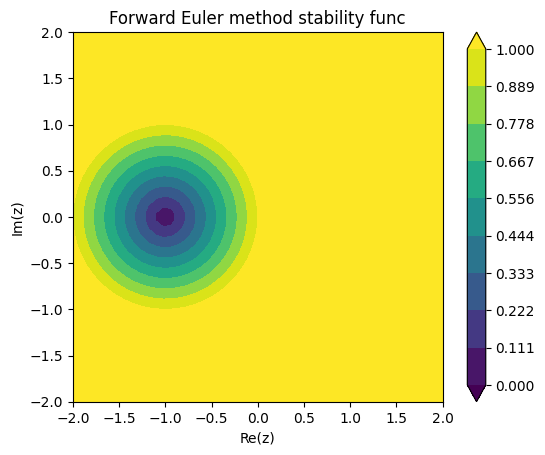

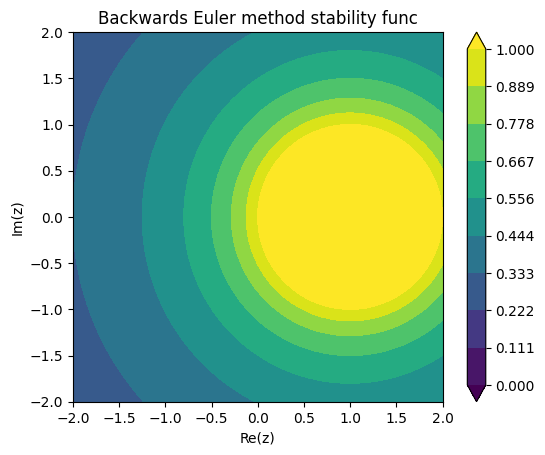

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Setting up a grid in the complex plane
z_re = np.linspace(-2, 2, 50)
z_im = z_re
z_re_grid, z_im_grid = np.meshgrid(z_re, z_im)
z = z_re_grid + 1j*z_im_grid

# Forward Euler stability function 
R_forward_euler = lambda z: np.abs(1 + z)
# Backwards Euler
R_backward_euler = lambda z: np.abs(1/(1 - z))

# A handy utility function for plotting contours of R(z)
def plot(R, title):
    levels = np.linspace(0, 1, 10)
    fig, ax = plt.subplots(1, 1)
    ax.set_aspect("equal")
    ax.set_xlabel("Re(z)")
    ax.set_ylabel("Im(z)")
    ax.set_title(title)
    cs = ax.contourf(z_re_grid, z_im_grid, R(z), levels, extend = 'both')
    cbar = fig.colorbar(cs)
    plt.plot()

plot(R_forward_euler, "Forward Euler method stability func")
plot(R_backward_euler, "Backwards Euler method stability func")

We see from these plots that the forward Euler method is not A-stable: it is not stable for $\lambda h < -2$ for negative, real $\lambda$. The backwards Euler method, however, is A-stable. 

Explicit methods in general polynomial stability functions and therefore **bounded** stability regions, meaning that for large enough negative $\lambda$ values, they will need extremely small stepsizes to stay stable. This will eventually lead to conditioning issues. Implicit methods mitigate this, but at the expense of having to solve a linear system at each step, which adds non-negligible computational cost.

```{admonition} Exercises
:class: danger

1. (Quiz 3)

Read the question before starting. You may wish to do part c) first if your answer to b) doesn't look right.

The Butcher tableau below this exercise block describes an embedded Runge--Kutta pair.


- a) Implement a function, `step(...)`, that takes parameters `f` (callable), `u0` (vector), and `h` (float), where `f` is the function $f(t, u)$ that encodes the right-hand-side of a linear ODE system, `u0` is $u_0$, the solution vector at the start of the timestep (say, $t = t_0$), and `h` is $h$, the timestep. The function should return $u$, the solution at $t_0 + h$ computed via the $b$ coefficients, and $u^{\ast}$, another estimate but evaluated using the $b^{\ast}$ coefficients.
- b) Create a convergence plot (with log-log axes) of $u$ and $u^{\ast}$ as a function of $h$, referenced against a known solution of a simple ODE. The x-axis should span a few orders of magnitude of $h$ so that you can read off the convergence rate. What is it for these two estimates? Deduce the order of this embedded Runge--Kutta method (you should get two orders). 
- c) Write a unit test for the `step(...)` function that checks whether a simple ODE is solved _exactly_. Explain why the ODE you came up with should be solved exactly by this Runge--Kutta method.
- d) Write a nice docstring for the `step(...)` function.

2. (Quiz 3)

- a) Write a function, `stepsize(...)` that takes parameters `err` (float), and `atol` (float). `err` will mean a worst-offender error, the maximum of the LTE of `u`. `atol` is an absolute tolerance. This function should return `accept` (boolean), and `h` (float), which are a boolean variable indicating whether the current step is accepted or not, and `h` is the suggested next stepsize. The function should implement the basic stepsize-updater formula described in section 7.4 above. Add a simple maximum stepsize (say, `h = 100`), to prevent the function from returning `h = inf` (this can happen when an ODE is solved exactly).
- b) Write a nice docstring for the `stepsize(...)` function.

3. (Quiz 3)

- a) Write a function, `solve(...)` that takes parameters `f`, `u0`, `t0` (float), `t1` (float), and `atol` (float). The first two parameters are as above, `t0` and `t1` define the ODE's solution range, and `atol` is an absolute tolerance. This function should call `step()` repeatedly and update $t \to t+h$, until `t1` is reached. Each next guess for $h$ should be obtained from `stepsize(...)`, and a step should only be accepted if its LTE is below the tolerance `atol`.
- b) Write a "unit test" (at this point, it's more of an integration test) for this function. It should be similar to the one you wrote in 1.c.
- c) Write a nice dosctring for `solve(...)`.

4. (Quiz 3)

Write a function that plots the stability region of this Runge--Kutta method, and explain your work. Comment on the plot. What is the maximum negative $\lambda$ for which the solution of $u' = \lambda u$ is stable with this method, assuming a constant stepsize of $h = 0.01$?

```

```{list-table}
:header-rows: 4

* - $0$  
  - $ $ 
  - $ $ 
  - $ $ 
  - $ $
* - $1$  
  - $1$ 
  - $ $
  - $ $
  - $ $
* - $1/2$  
  - $3/8$
  - $ 1/8$
  - $ $
  - $ $
* - $1$  
  - $-6.5$   
  - $ -2.5$
  - $ 10 $
  - $ $ 
* - $ b $
  - $1/2$ 
  - $1/2s$
  - $ 0 $
  - $ $   
* - $ b^{\ast} $ 
  - $ 1/6$
  - $2/15$ 
  - $2/3 $
  - $1/30$
```